# INNIO Fleet Analysis

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
import bokeh
from bokeh.models import Span, Text, Label
from collections import namedtuple
from pprint import (pprint as pp, pformat as pf)
import time
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML
import ipywidgets as widgets
import arrow

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)
from dfsm import msgFSM

### Filter Engines from installed fleet 

In [2]:
def sfun(x):
    return all([
            ("Forsa Hartmoor" in str(x['IB Site Name'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])


In [13]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
pname = 'persist.json'
try:
    persist_dialog = dmyplant2.load_json(pname)
except FileNotFoundError:        
    persist_dialog = {
        'dl': 0,
        'modes': [
                {'name':'???','value':False },
                {'name':'OFF','value':False },
                {'name':'MANUAL','value':False},
                {'name':'AUTO','value':True }],
        'starts': [   
                {'name':'True','value':True },
                {'name':'False','value':False }]   
    }
    dmyplant2.save_json(pname,persist_dialog)

In [12]:
    fleet.T

,0,1,2,3,4,5,6,7,8,9,10
Count_OpHour,188.0,185.0,172.0,165.0,180.0,185.0,170.0,157.0,158.0,121.0,157.0
OperationalCondition,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available
shutdown_counter,136.0,105.0,98.0,99.0,99.0,97.0,91.0,85.0,90.0,82.0,93.0
startup_counter,136.0,103.0,98.0,99.0,98.0,95.0,91.0,85.0,90.0,80.0,88.0
id,159396,159397,159399,159398,159400,159401,159403,159402,159404,159405,159406
Engine Version,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12
Engine Type,624,624,624,624,624,624,624,624,624,624,624
Engine Series,6,6,6,6,6,6,6,6,6,6,6
Country,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB
Commissioning Date,2022-01-10,2022-01-10,2022-01-11,2022-01-11,2022-01-22,2022-01-10,2022-01-11,2022-01-11,2022-01-11,2022-01-22,2022-01-11


In [14]:
# Dialog
persist_dialog = dmyplant2.load_json(pname)
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
#dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
dl=widgets.Dropdown(options = ddl,value=persist_dialog['dl'],description='Engine:',layout={'width':'auto'},disabled=False)
out = widgets.Output(layout={'height':'auto', 'width':'auto'})
rmodes = persist_dialog['modes']
service_selector_modes = [] 
modes = []
for mm in rmodes:
    service_selector_modes.append(widgets.Checkbox(
        value=mm['value'], 
        description=mm['name'],
        layout={'width':'auto'},
        disabled=False,indent=False))

rsucc = persist_dialog['starts']
successful_starts = []; 
for rs in rsucc:
    successful_starts.append(widgets.Checkbox(
            value=(str(rs['value']) == rs['name']),
            description=rs['name'],
            layout={'width':'auto'},
            disabled=False,indent=False))

app = AppLayout(  header=dl,
            #left_sidebar=Button(description='center', button_style='warning', layout=Layout(height='auto', width='auto')),
            left_sidebar=None,
            center=HBox([
                VBox(service_selector_modes),
                VBox(successful_starts),
                out
            ]),
            right_sidebar=None,
            footer = None,
            #footer = Button(description='footer', button_style='success', layout=Layout(height='auto', width='auto')),
            pane_widths=['10px',1,'10px'],
            pane_heights=['40px','250px','40px']
            )
display(app)

AppLayout(children=(Dropdown(description='Engine:', index=1, layout=Layout(grid_area='header', width='auto'), …

In [22]:
# Load Engine Data and execute FSM Run 1 - display Results 
persist_dialog = {
    'dl':dl.value, 
    'modes': [{'name':cb.description, 'value':cb.value} for cb in service_selector_modes],
    'starts': [{'name':cb.description, 'value': str(cb.value) == cb.description} for cb in successful_starts]}

dmyplant2.save_json(pname,persist_dialog)
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=arrow.now(), frompickle=True)
fsm.run1(enforce=False) # run Finite State Machine
fsm.store()
out.clear_output()
with out:
    fsm.summary_out()
rdf = fsm.result
#rdf[fsm.filters['filter_content']].round(2)
modes = [rmodes[i]['name'] for i,v in enumerate(service_selector_modes) if v.value]
success = [rsucc[i]['value'] for i,v in enumerate(successful_starts) if v.value]
rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))]
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
print(modes, success)
rda[fsm.filters['filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

['???', 'OFF', 'MANUAL', 'AUTO'] [True, False]


,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,targetoperation,coolrun,count_alarms,count_warnings
0,False,???,98.27,3.63,22.47,67.27,NaN,NaN,191.64,NaT,NaN,0,0
1,False,???,93.91,3.84,20.27,6.36,69.75,44.97,239.09,NaT,NaN,0,0
2,False,???,4.24,NaN,NaN,NaN,NaN,NaN,4.24,NaT,NaN,0,0
3,False,MANUAL,98.01,NaN,NaN,NaN,NaN,NaN,98.01,NaT,NaN,0,0
4,False,AUTO,60.64,4.14,18.26,5.65,55.53,46.17,190.39,NaT,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,True,AUTO,102.09,3.74,19.69,4.45,65.49,81.12,15486.89,0 days 04:12:32,58.56,0,0
87,True,AUTO,101.27,4.04,23.71,4.84,48.66,94.52,19087.95,0 days 05:12:29,61.86,0,0
88,True,AUTO,102.80,3.93,23.40,4.64,1.51,138.89,11885.53,0 days 03:12:32,58.44,0,0
89,True,AUTO,100.13,3.74,23.63,4.44,46.84,96.98,6487.79,0 days 01:42:30,61.57,0,0


In [23]:
# Execute FSM Run 2
rda = fsm.run2(rda)
fsm.store()

FSM Run2: 100%|████████████████████████████| 91/91 [01:08<00:00,  1.33 starts/s]


In [24]:
rdb = rda
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb[fsm.filters['run2filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

,index,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,coolrun,count_alarms,count_warnings
0,0,False,???,98.27,3.63,22.47,67.27,NaN,NaN,191.64,0.00,NaN,NaT,NaN,0,0
1,1,False,???,93.91,3.84,20.27,6.36,69.75,-193.53,0.59,0.00,-0.00,NaT,NaN,0,0
2,2,False,???,4.24,NaN,NaN,NaN,NaN,NaN,4.24,0.00,NaN,NaT,NaN,0,0
3,3,False,MANUAL,98.01,NaN,NaN,NaN,NaN,NaN,98.01,0.00,NaN,NaT,NaN,0,0
4,4,False,AUTO,60.64,4.14,18.26,5.65,55.53,1305.23,1449.45,4491.20,0.08,NaT,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,True,AUTO,102.09,3.74,19.69,4.45,65.49,82.82,278.27,4516.40,1.21,0 days 04:12:32,58.56,0,0
87,87,True,AUTO,101.27,4.04,23.71,4.84,48.66,97.35,279.86,4584.89,1.05,0 days 05:12:29,61.86,0,0
88,88,True,AUTO,102.80,3.93,23.40,4.64,1.51,143.34,279.62,4564.10,0.71,0 days 03:12:32,58.44,0,0
89,89,True,AUTO,100.13,3.74,23.63,4.44,46.84,98.79,277.57,4524.65,1.02,0 days 01:42:30,61.57,0,0


,startpreparation,hochlauf,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,coolrun
count,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00
mean,98.83,20.69,5.00,34.17,211.61,4493.17,0.82,374.27,59.93
std,54.52,2.22,0.73,21.41,697.88,181.61,0.21,700.68,1.59
min,0.60,17.15,4.04,0.80,81.24,3056.28,0.02,234.85,56.03
25%,85.09,18.72,4.39,8.64,105.36,4491.42,0.72,277.62,58.21
50%,100.35,20.17,4.74,35.21,128.57,4503.00,0.78,279.62,60.98
75%,102.25,22.68,5.56,53.26,138.60,4526.14,0.89,288.90,61.23
max,362.91,25.53,6.35,65.49,5834.49,4636.51,1.25,6009.67,61.94


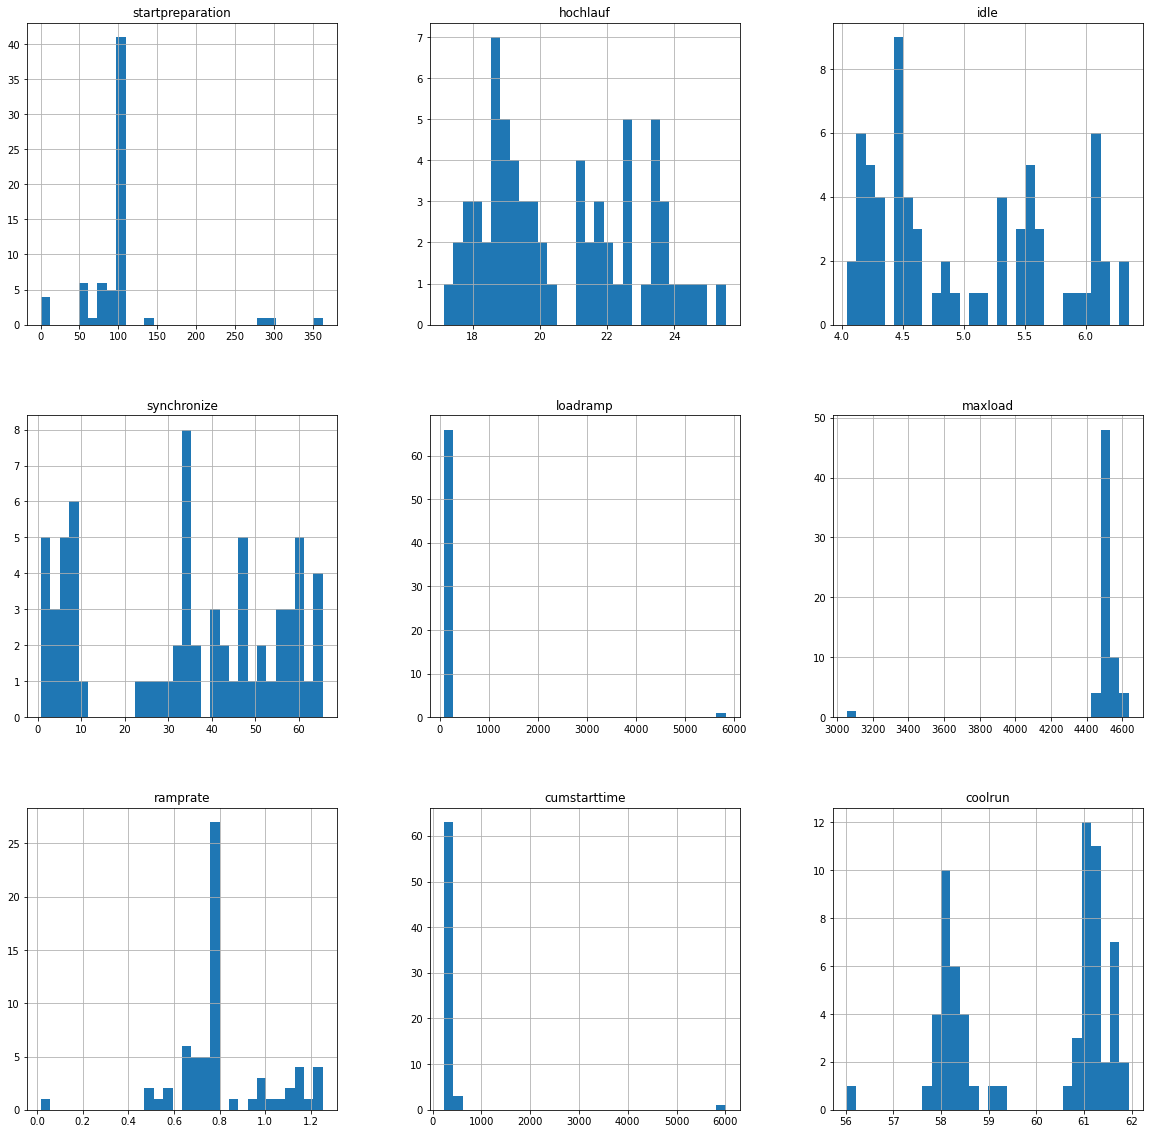

In [25]:
display(_=rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','coolrun']].dropna().hist(bins=30,figsize=(20,20)))
display(rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','coolrun']].dropna().describe().round(2))

In [26]:
a = widgets.widgets.IntSlider(min=0,max=rdb.shape[0]-1)
w = widgets.IntText()
display(HBox([a,w]))
mylink = widgets.jslink((a, 'value'), (w, 'value'))

In [27]:
v = max(min(w.value,rdb.shape[0]-1),0)
startversuch = rdb.iloc[v];
von_dt=pd.to_datetime(startversuch['starttime']); von=int(von_dt.timestamp())
bis_dt=pd.to_datetime(startversuch['endtime']); bis=int(bis_dt.timestamp())

ftitle = f"{fsm._e} ----- Start {startversuch['index']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
print(ftitle, end=' ')
print(f"von: {von_dt.strftime('%d.%m.%Y %H:%M:%S')} = {von} bis: {bis_dt.strftime('%d.%m.%Y %H:%M:%S')} = {bis}")
vset = fsm._data_spec + ['Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
global data
data = fsm.get_cycle_data2(startversuch, max_length=900, min_length=None, cycletime=1, silent=False, p_data=vset)
#fsm._debug(int(startversuch['starttime'].timestamp() * 1000),int(startversuch['endtime'].timestamp() * 1000),data,'data')

dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]
pl, _ = fsm.detect_edge_left(data, 'Power_PowerAct', startversuch)
pr, _ = fsm.detect_edge_right(data, 'Power_PowerAct', startversuch)
sl, _ = fsm.detect_edge_left(data, 'Various_Values_SpeedAct', startversuch)
sr, _ = fsm.detect_edge_right(data, 'Various_Values_SpeedAct', startversuch)
fsm.disp_result(startversuch)
al_lines = fsm.disp_alarms(startversuch)
w_lines = fsm.disp_warnings(startversuch)
fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, grid=False, figsize=(16,10), style='line', line_width=0)
dmyplant2.add_dbokeh_vlines(al_lines,fig,line_color='purple', line_dash='dashed', line_alpha=1, line_width=2)
dmyplant2.add_dbokeh_vlines(w_lines,fig,line_color='brown', line_dash='dashed', line_alpha=1, line_width=2)
dmyplant2.add_dbokeh_vlines(fsm.states_lines(startversuch),fig,line_color='red', line_dash='solid', line_alpha=0.4)
                        
#fsm run 2 results
lcol='blue'
dmyplant2.add_dbokeh_vlines([sl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
dmyplant2.add_dbokeh_vlines([sr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
dmyplant2.add_dbokeh_vlines([pl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
dmyplant2.add_dbokeh_vlines([pr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)

fig.add_layout(Span(location=fsm._e['Power_PowerNominal'],dimension='width',x_range_name='default', y_range_name='0',line_color='red', line_dash='solid', line_alpha=0.4)) 
if 'maxload' in startversuch:
    fig.add_layout(Span(location=startversuch['maxload'],dimension='width',x_range_name='default', y_range_name='0',line_color='red', line_dash='solid', line_alpha=0.4)) 
fig.add_layout(Span(location=1500,dimension='width',x_range_name='default', y_range_name='1',line_color='blue', line_dash='solid', line_alpha=0.4)) 
bokeh.plotting.show(fig)

1486152 Forsa Hartmoor M02 ----- Start 86 AUTO | SUCCESS | 2022-02-19 15:15:06 von: 19.02.2022 15:15:05 = 1645283705 bis: 19.02.2022 19:33:12 = 1645299192


startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,coolrun
102.085999,3.736,19.689,4.445999,65.485999,82.822003,278.265,4516.401,1.213157,0 days 04:12:32,58.562999


In [ ]:
# pure matplotlib chart
# fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
# dmyplant2.add_vlines(fsm.states_lines(startversuch), ax, color='gray', linestyle="-.")

In [ ]:
# Edge detection algorithm speed - visualization
# dset = [
#     {'col':['Various_Values_SpeedAct','Various_Values_SpeedAct_right'], 'ylim':(0,20000)},
#     {'col':['helpline_right'], 'color':'gray','ylim':(0,20000)}
# ]
# # pr, _ = fsm.detect_edge_right(data, 'Various_Values_SpeedAct', right=startversuch['endtime'])
# # fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(14,8), style='line', line_width=0)
# pr, ndata = fsm.detect_edge_right(data, 'Various_Values_SpeedAct', right=startversuch['endtime'])
# fig = dmyplant2.dbokeh_chart(ndata, dset, title=ftitle, figsize=(14,8), style='line', line_width=0)
# dmyplant2.add_dbokeh_vlines([pr.loc], fig,line_color='red', line_dash='solid', line_alpha=0.4)
# bokeh.plotting.show(fig)

In [ ]:
# Edge detection algorithm speed - visualization
# dset = [
#     {'col':['Various_Values_SpeedAct','Various_Values_SpeedAct_left','Various_Values_SpeedAct_right','helpline_left','helpline_right'], '_ylim':(0,4000)},
# ]
# pr, ndata = fsm.detect_edge_right(data, 'Various_Values_SpeedAct', right=startversuch['endtime'])
# pl, ndata = fsm.detect_edge_left(ndata, 'Various_Values_SpeedAct', left=startversuch['starttime'])
# fig = dmyplant2.dbokeh_chart(ndata, dset, title=ftitle, figsize=(14,8), style='line', line_width=0)
# # pl, _ = fsm.detect_edge_left(data, 'Various_Values_SpeedAct', left=startversuch['starttime'])
# # fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(14,8), style='line', line_width=0)
# dmyplant2.add_dbokeh_vlines([pl.loc], fig,line_color='red', line_dash='solid', line_alpha=0.4)
# dmyplant2.add_dbokeh_vlines([pr.loc], fig,line_color='red', line_dash='solid', line_alpha=0.4)
# bokeh.plotting.show(fig)

In [ ]:
# Edge detection algorithm power - visualization
# dset = [
#     {'col':['Power_PowerAct','Power_PowerAct_left','Power_PowerAct_right'], '_ylim':(0,40000)}
# ]
# #pl, _ = fsm.detect_edge_left(data, 'Power_PowerAct', left=startversuch['starttime'])
# pl, _ = fsm.detect_edge_left(data, 'Power_PowerAct', startversuch=startversuch)
# pr, _ = fsm.detect_edge_right(data, 'Power_PowerAct', right=startversuch['endtime'])
# fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(6,3), style='line', line_width=0)
# dmyplant2.add_dbokeh_vlines([pl.loc], fig,line_color='red', line_dash='solid', line_alpha=0.4)
# dmyplant2.add_dbokeh_vlines([pr.loc], fig,line_color='red', line_dash='solid', line_alpha=0.4)
# bokeh.plotting.show(fig)

In [ ]:
# # Edge detection algorithm power & speed - visualization
# dset = [
#     {'col':['Power_PowerAct','Various_Values_SpeedAct'], 'ylim':(0,30000)},
#     {'col':['Power_PowerAct_left','Power_PowerAct_right','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], 'ylim':(0,30000)}
#     ]
# pl, _ = fsm.detect_edge_left(data, 'Power_PowerAct', startversuch)
# pr, _ = fsm.detect_edge_right(data, 'Power_PowerAct', startversuch)
# sl, _ = fsm.detect_edge_left(data, 'Various_Values_SpeedAct', startversuch)
# sr, _ = fsm.detect_edge_right(data, 'Various_Values_SpeedAct', startversuch)
# #fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
# fsm.disp_result(startversuch)
# al_lines = fsm.disp_alarms(startversuch)
# w_lines = fsm.disp_warnings(startversuch)

# fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(14,8), style='line', line_width=0)
# dmyplant2.add_dbokeh_vlines(al_lines,fig,line_color='purple', line_dash='dashed', line_alpha=1, line_width=2)
# dmyplant2.add_dbokeh_vlines(w_lines,fig,line_color='brown', line_dash='dashed', line_alpha=1, line_width=2)
# dmyplant2.add_dbokeh_vlines(fsm.states_lines(startversuch), fig,line_color='red', line_dash='solid', line_alpha=0.4)
# lcol='blue'
# dmyplant2.add_dbokeh_vlines([sl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
# dmyplant2.add_dbokeh_vlines([sr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
# dmyplant2.add_dbokeh_vlines([pl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
# dmyplant2.add_dbokeh_vlines([pr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
# bokeh.plotting.show(fig)

In [ ]:
# iterate over Result
p_dat = fsm._data_spec + ['Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], '_ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'_ylim': [0, 2500], 'color':'blue'},
    {'col':['Hyd_PressCrankCase'],'_ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'_ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'_ylim': [60, 110], 'color':'#2171b5'}
]
def crawl_result(rda, srange = None, p_figsize=(16,10)):
        if srange == None:
                srange = [s['index'] for i,s in rda.iterrows()] # too much memory needed !!
                #srange = [s for s in range(2)] # limit to 2 in the interim 
        else:
                if isinstance(srange,int):
                        srange = [srange]
                elif not isinstance(srange,list):
                        raise ValueError(f"crawl_result: invalid parameter! srange={srange}")
        print(srange)
        for ii,startversuch in rda.iterrows():
                if startversuch['index'] in srange:
                        data = fsm.get_cycle_data(startversuch, max_length=None, min_length=None, cycletime=1, silent=True, p_data=p_dat)
                        print(data.shape)
                        pl, _ = fsm.detect_edge_left(data, 'Power_PowerAct', startversuch)
                        pr, _ = fsm.detect_edge_right(data, 'Power_PowerAct', startversuch)
                        sl, _ = fsm.detect_edge_left(data, 'Various_Values_SpeedAct', startversuch)
                        sr, _ = fsm.detect_edge_right(data, 'Various_Values_SpeedAct', startversuch)
                        # code ?
                        ml = (data.iloc[-1]['time'] - data.iloc[0]['time']) // 1000
                        sv_lines = [v for v in startversuch[fsm.filters['vertical_lines_times']]]
                        nsv_lines = [v for v in sv_lines if ((v==v) and (v <= ml)) ]
                                
                        svdf = pd.DataFrame(sv_lines, index=fsm.filters['vertical_lines_times'], columns=['FSM']).fillna(0)
                        svdf['RUN2'] = svdf['FSM']
                        #if svdf.at['hochlauf','FSM'] > 0.0:
                        #        svdf.at['hochlauf','RUN2'] = sl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['starter']
                        #        svdf.at['idle','RUN2'] = svdf.at['idle','FSM'] - (svdf.at['hochlauf','RUN2'] - svdf.at['hochlauf','FSM'])
                        if svdf.at['loadramp','FSM'] > 0.0:
                                svdf.at['loadramp','RUN2'] = pl.loc.timestamp() - startversuch['starttime'].timestamp() - np.cumsum(svdf['RUN2'])['synchronize']
                        with warnings.catch_warnings():
                                warnings.simplefilter("ignore")
                                svdf = pd.concat([
                                        svdf, 
                                        pd.DataFrame.from_dict(
                                                {       'maxload':['-',pl.val],
                                                        'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],
                                                        'cumstarttime':[np.cumsum(svdf['FSM'])['loadramp'], np.cumsum(svdf['RUN2'])['loadramp']]
                                                }, 
                                                columns=['FSM','RUN2'],
                                                orient='index')]
                                        )

                        ftitle = f"{fsm._e} ----- Start {startversuch['index']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
                        #display(HTML('<h3>'+ f"{fsm._e} ----- Start {startversuch['index']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}" + '</h3>'))
                        
                        fsm.disp_result(startversuch)
                        al_lines = fsm.disp_alarms(startversuch)
                        w_lines = fsm.disp_warnings(startversuch)

                        fig = dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=p_figsize, style='line', line_width=0)
                        #fsm results
                        dmyplant2.add_dbokeh_vlines(fsm.states_lines(startversuch), fig,line_color='red', line_dash='solid', line_alpha=0.4)
                        
                        #alarms & warnings
                        dmyplant2.add_dbokeh_vlines(al_lines,fig,line_color='purple', line_dash='dashed', line_alpha=1, line_width=2)
                        dmyplant2.add_dbokeh_vlines(w_lines,fig,line_color='brown', line_dash='dashed', line_alpha=1, line_width=2)
                        
                        #fsm run 2 results
                        lcol='blue'
                        dmyplant2.add_dbokeh_vlines([sl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
                        dmyplant2.add_dbokeh_vlines([sr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
                        dmyplant2.add_dbokeh_vlines([pl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
                        dmyplant2.add_dbokeh_vlines([pr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)

                        fig.add_layout(Span(location=fsm._e['Power_PowerNominal'],dimension='width',x_range_name='default', y_range_name='0',line_color='red', line_dash='solid', line_alpha=0.4)) 
                        fig.add_layout(Span(location=startversuch['maxload'],dimension='width',x_range_name='default', y_range_name='0',line_color='red', line_dash='solid', line_alpha=0.4)) 
                        fig.add_layout(Span(location=1500,dimension='width',x_range_name='default', y_range_name='1',line_color='blue', line_dash='solid', line_alpha=0.4)) 

                        bokeh.plotting.show(fig)

print(f"Number of Starts in Result: {rdb.shape[0]}")
rdb[fsm.filters['run2filter_content']].round(2)


In [ ]:
rdc = rda[rda['cumstarttime'] > 300.0]
rdc[fsm.filters['run2filter_content']].round(2)

In [ ]:
rdd = rda[(rda['loadramp'] < 100.0) & (rda['maxload'] > 4000.0)]
rdd = rdd.sort_values(by = "index",ascending=True).reset_index(drop='index').round(2)
rdd[['starttime']+fsm.filters['run2filter_content']]

In [ ]:
crawl_result(rdd, 41, p_figsize=(17,10))

In [ ]:
rde = rda[rda.starttime > fsm._e['Commissioning Date']]
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-50,650)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'black'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'green'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dmyplant2.dbokeh_chart(rde, dset, x='starttime', figsize=(16,10) ,title=ftitle);
bokeh.plotting.show(fig)

In [ ]:
rda[['startpreparation','starter','hochlauf','idle','synchronize','cumstarttime','loadramp','targetoperation']].hist(figsize = (20,12), bins=80, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
fsm._target_load_message